In [37]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np   
import pandas as pd    
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor,RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, train_test_split
pd.set_option('display.max_columns', None)
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
    precision_recall_curve,
    roc_curve,
    classification_report,
    make_scorer,
    precision_recall_fscore_support
)

In [2]:
data = pd.read_excel("Tourism.xlsx", 1)
display(data)

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
0,200000,1,41.0,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Deluxe,3.0,Single,1.0,1,2,1,0.0,Manager,20993.0
1,200001,0,49.0,Company Invited,1,14.0,Salaried,Male,3,4.0,Deluxe,4.0,Divorced,2.0,0,3,1,2.0,Manager,20130.0
2,200002,1,37.0,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Basic,3.0,Single,7.0,1,3,0,0.0,Executive,17090.0
3,200003,0,33.0,Company Invited,1,9.0,Salaried,Female,2,3.0,Basic,3.0,Divorced,2.0,1,5,1,1.0,Executive,17909.0
4,200004,0,NaN,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Basic,4.0,Divorced,1.0,0,5,1,0.0,Executive,18468.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4883,204883,1,49.0,Self Enquiry,3,9.0,Small Business,Male,3,5.0,Deluxe,4.0,Unmarried,2.0,1,1,1,1.0,Manager,26576.0
4884,204884,1,28.0,Company Invited,1,31.0,Salaried,Male,4,5.0,Basic,3.0,Single,3.0,1,3,1,2.0,Executive,21212.0
4885,204885,1,52.0,Self Enquiry,3,17.0,Salaried,Female,4,4.0,Standard,4.0,Married,7.0,0,1,1,3.0,Senior Manager,31820.0
4886,204886,1,19.0,Self Enquiry,3,16.0,Small Business,Male,3,4.0,Basic,3.0,Single,3.0,0,5,0,2.0,Executive,20289.0


In [3]:
data.isna().sum()

CustomerID                    0
ProdTaken                     0
Age                         226
TypeofContact                25
CityTier                      0
DurationOfPitch             251
Occupation                    0
Gender                        0
NumberOfPersonVisiting        0
NumberOfFollowups            45
ProductPitched                0
PreferredPropertyStar        26
MaritalStatus                 0
NumberOfTrips               140
Passport                      0
PitchSatisfactionScore        0
OwnCar                        0
NumberOfChildrenVisiting     66
Designation                   0
MonthlyIncome               233
dtype: int64

In [4]:
data = data.dropna(axis='rows')
data.shape

(4128, 20)

In [5]:
data = data.drop("CustomerID", axis = 1)
#sns.pairplot(data)

In [6]:
def histogram_boxplot(datas, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
   
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=datas, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=datas, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=datas, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        datas[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        datas[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

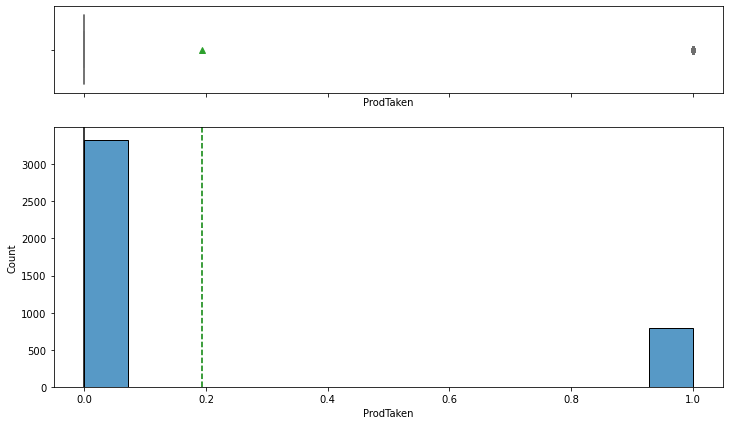

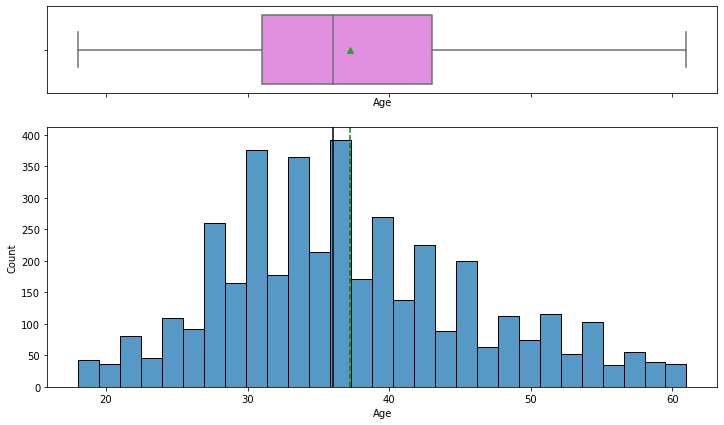

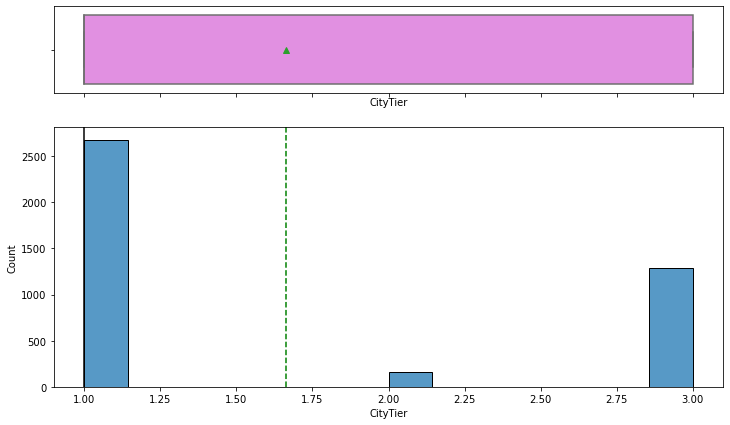

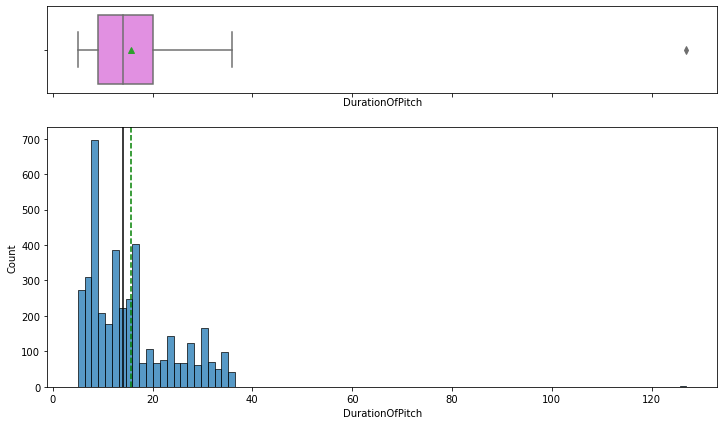

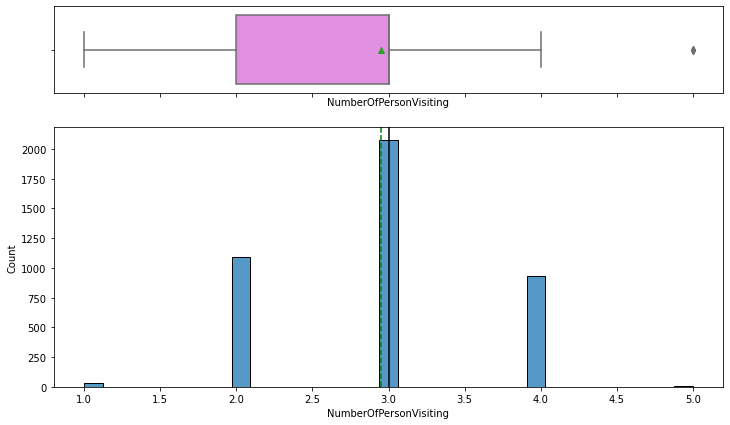

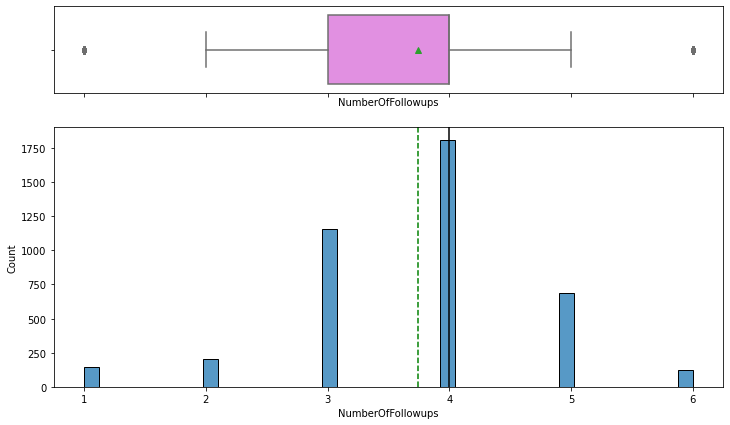

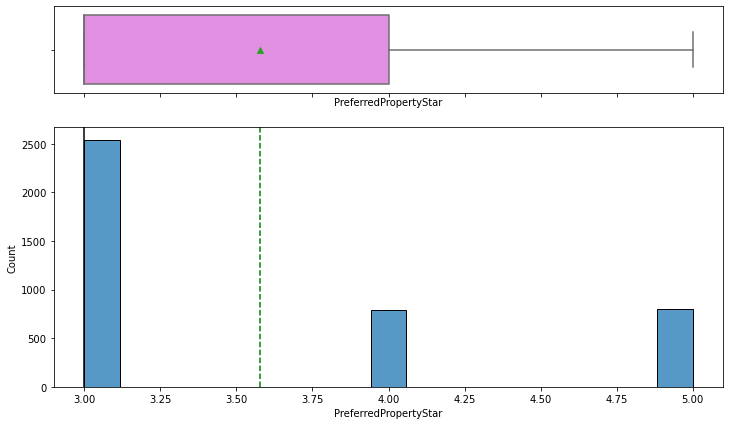

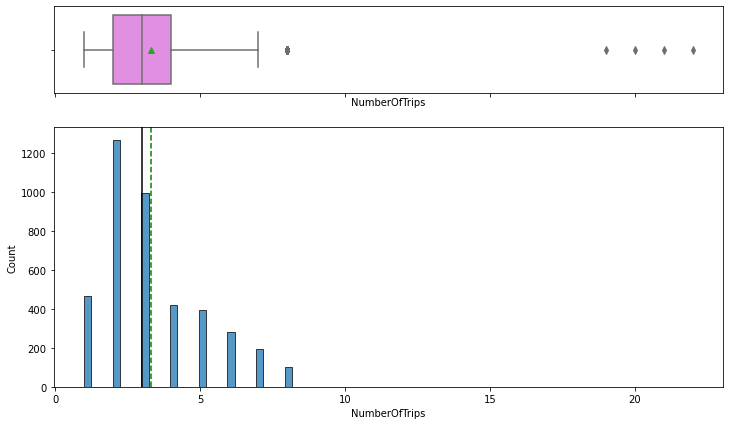

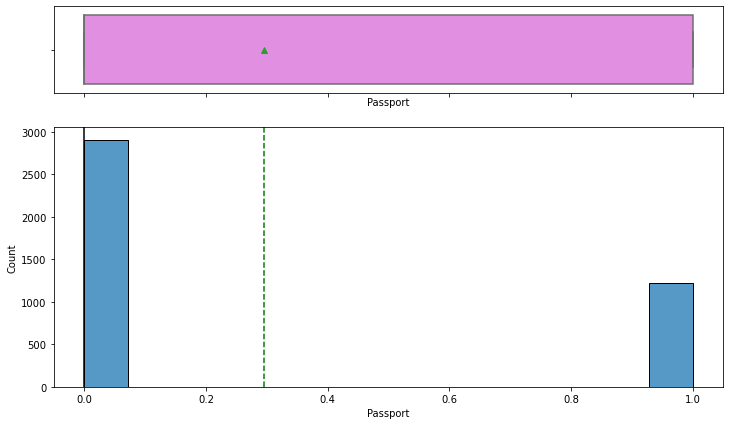

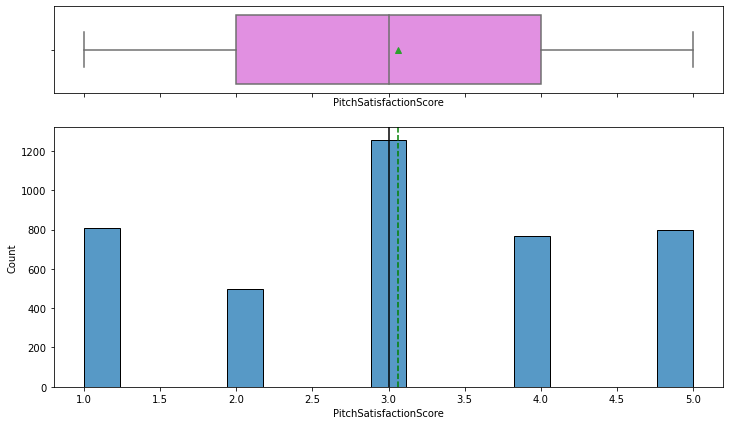

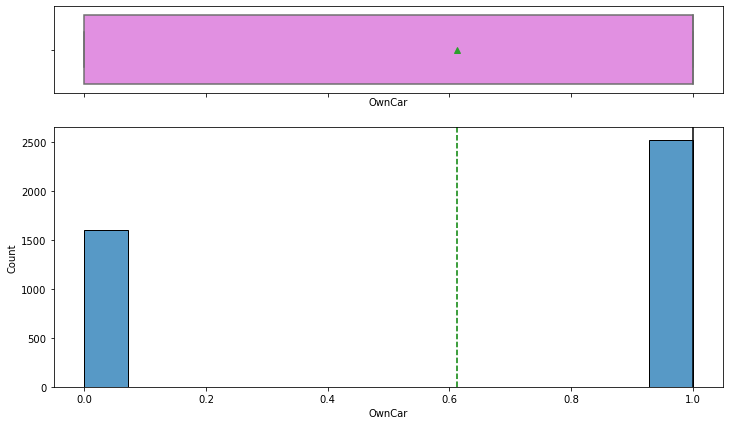

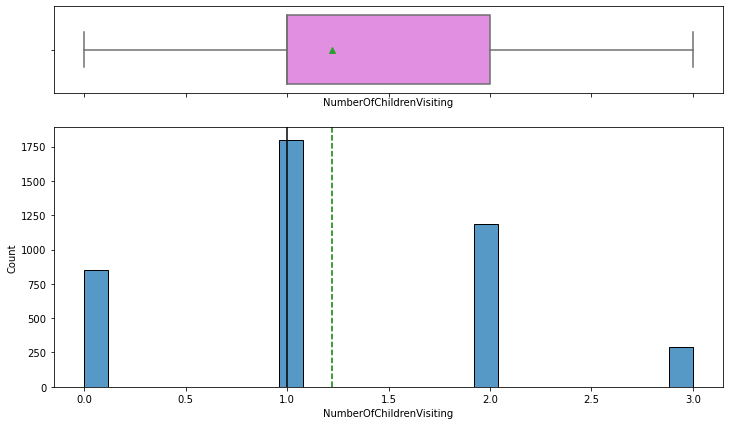

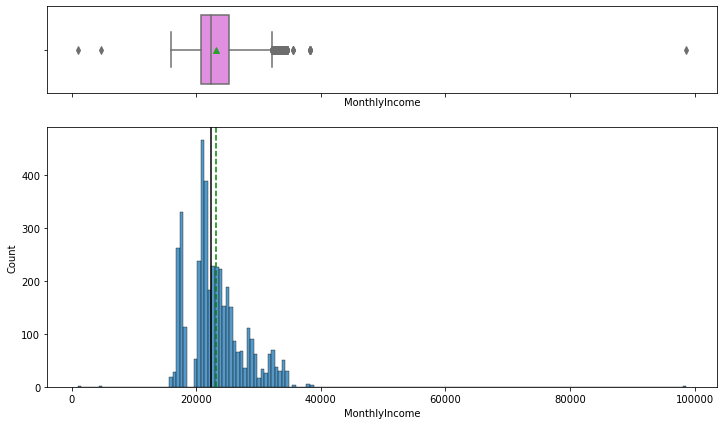

In [7]:
for x in data.select_dtypes(include=np.number).columns:
    histogram_boxplot(data, x, figsize=(12, 7), kde=False, bins=None)
    

In [8]:
def treat_outliers(df, col):
    """
    Treats outliers in a variable

    df: dataframe
    col: dataframe column
    """
    Q1 = df[col].quantile(0.25)  # 25th quantile
    Q3 = df[col].quantile(0.75)  # 75th quantile
    IQR = Q3 - Q1
    Lower_Whisker = Q1 - 1.5 * IQR
    Upper_Whisker = Q3 + 1.5 * IQR

    # all the values smaller than Lower_Whisker will be assigned the value of Lower_Whisker
    # all the values greater than Upper_Whisker will be assigned the value of Upper_Whisker
    df[col] = np.clip(df[col], Lower_Whisker, Upper_Whisker)
    return df

In [9]:
data = treat_outliers(data, "MonthlyIncome")
data = treat_outliers(data, "DurationOfPitch")

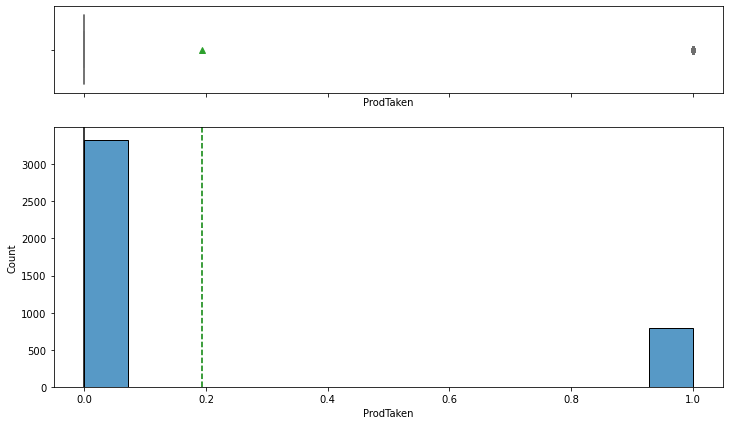

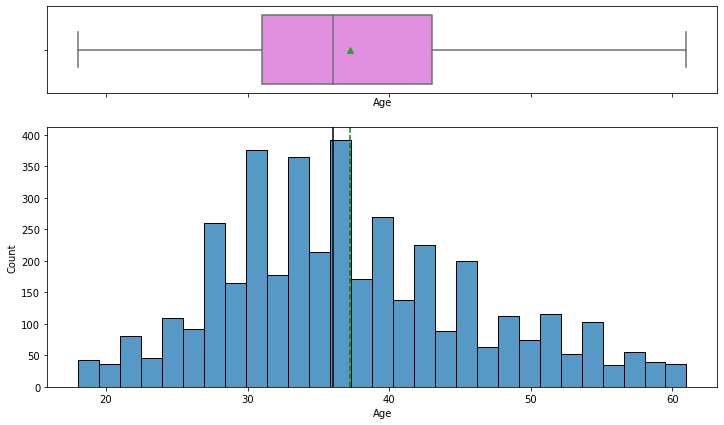

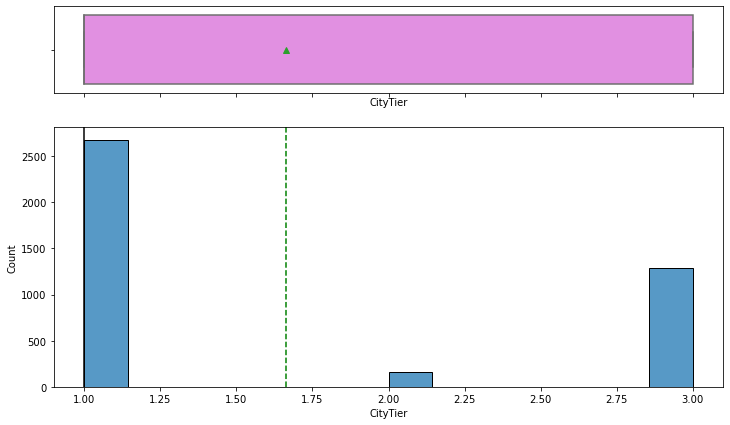

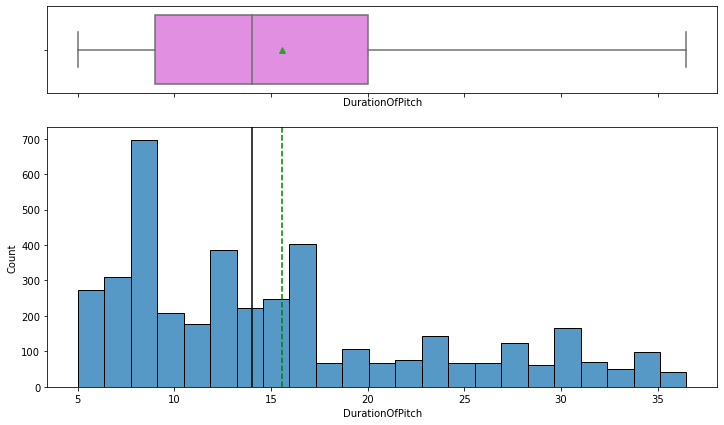

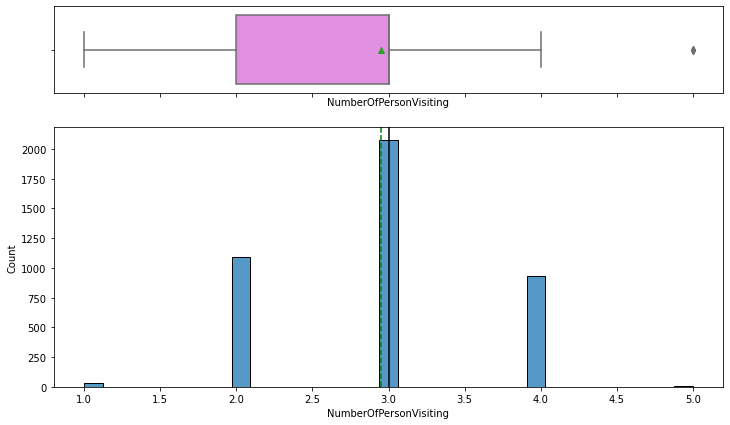

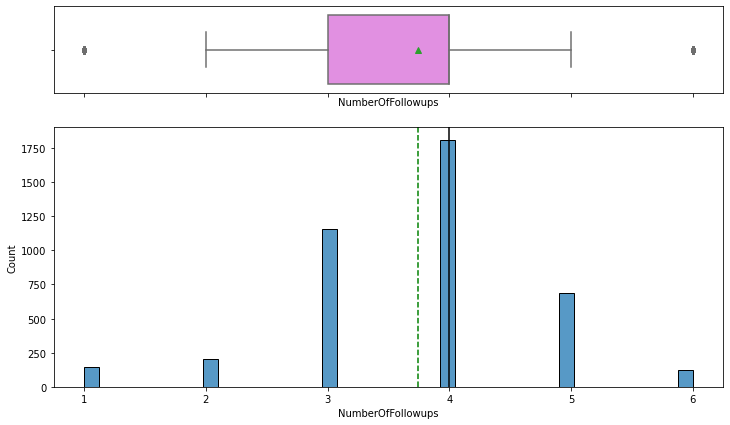

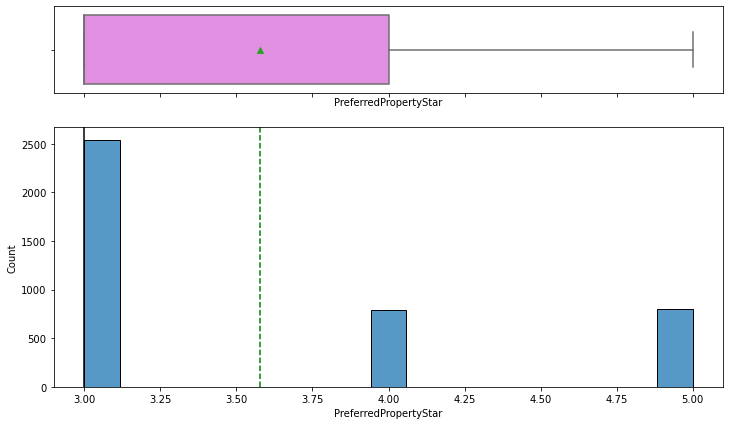

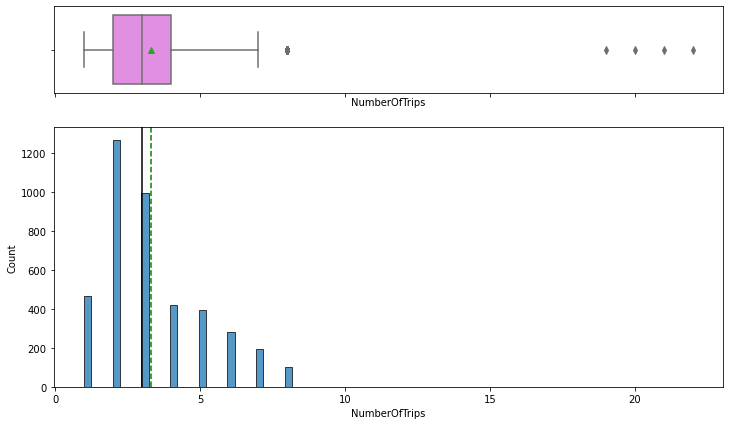

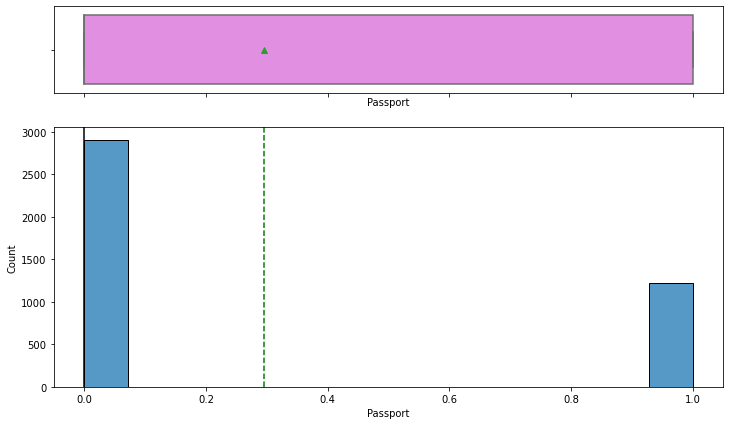

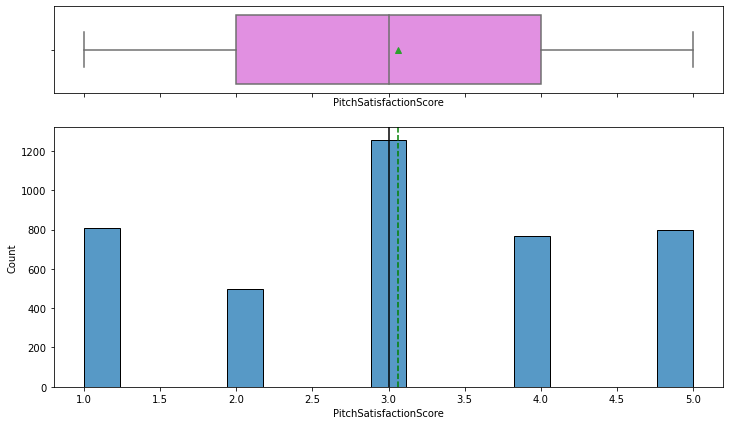

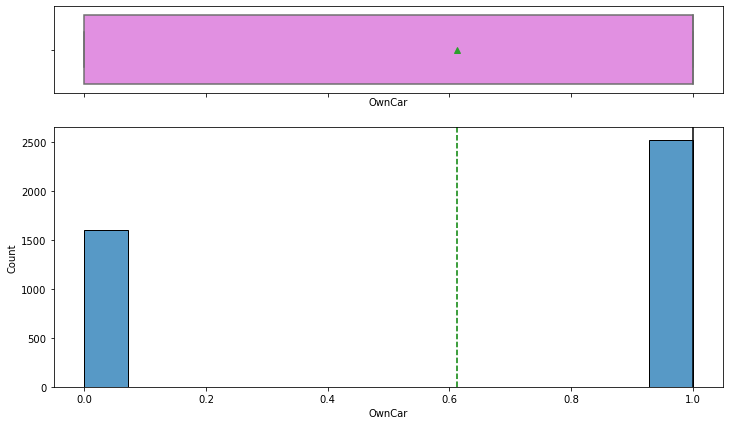

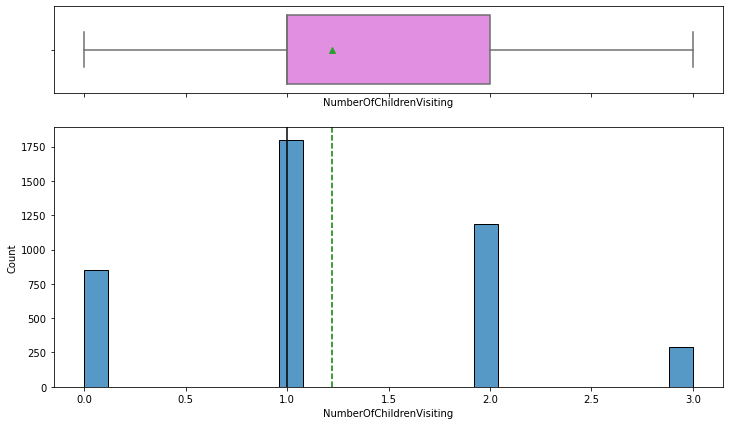

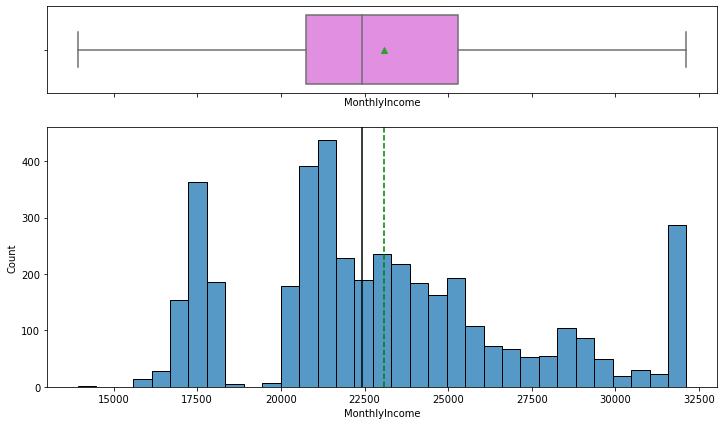

In [10]:
for x in data.select_dtypes(include=np.number).columns:
    histogram_boxplot(data, x, figsize=(12, 7), kde=False, bins=None)
    

In [11]:
data.describe()

,ProdTaken,Age,CityTier,DurationOfPitch,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,MonthlyIncome
count,4128.000000,4128.000000,4128.000000,4128.000000,4128.000000,4128.000000,4128.000000,4128.0000,4128.000000,4128.000000,4128.000000,4128.000000,4128.000000
mean,0.193072,37.231831,1.663275,15.562863,2.949370,3.741521,3.578488,3.2953,0.295300,3.060804,0.612161,1.223595,23092.437258
std,0.394757,9.174521,0.920640,8.223531,0.718818,1.006786,0.795031,1.8563,0.456233,1.363064,0.487317,0.852685,4151.701173
min,0.000000,18.000000,1.000000,5.000000,1.000000,1.000000,3.000000,1.0000,0.000000,1.000000,0.000000,0.000000,13926.000000
25%,0.000000,31.000000,1.000000,9.000000,2.000000,3.000000,3.000000,2.0000,0.000000,2.000000,0.000000,1.000000,20751.000000
50%,0.000000,36.000000,1.000000,14.000000,3.000000,4.000000,3.000000,3.0000,0.000000,3.000000,1.000000,1.000000,22418.000000
75%,0.000000,43.000000,3.000000,20.000000,3.000000,4.000000,4.000000,4.0000,1.000000,4.000000,1.000000,2.000000,25301.000000
max,1.000000,61.000000,3.000000,36.500000,5.000000,6.000000,5.000000,22.0000,1.000000,5.000000,1.000000,3.000000,32126.000000


UNIVARIATE ANALYSIS <br>
Prod Taken: There are far more people who decided not to buy the product than the amount who did. Approximately a fifth of the people who purchased packages purchased this product.  <br>
Age: Most of the people who purchased a travel package were between the ages of 30 and 40, with the mean being around 37 years old. <br>
City Tier: A lot more people live in high tier cities than lower tier cities. This implies that the people who buy these packages are at least moderately wealthy. <br>
Duration Of Pitch: It seems that most values are between 7 and 18 minutes, with the average being around 15 and a half minutes. This data is very right skewed, indicating some of the pitches last much longer than the mean. <br>
Number of Persons Visiting: In the past the number of people visiting has been 3. There are outliers at 1 and 5. <br>
Number of Follow Ups: The salesperson, in the past, has generally followed up 4 times with outliers at 1 and 6. <br>
Prefered Property Star: The prefered hotel rating for customers is right skewed at an average of 3.74 out of 5. <br>
Number of Trips: The number of annual trips for each customer is right skewed with an average of 3.29 and the mode being 2 trips. There are outliers and the maximum amount of trips any customer took at 22. <br>
Passport: Many customers do not have a passport. 2910 do not have a passport and 1218 customer do have a passport. <br>
Pitch Satisfaction Score: Most customers gave the sales pitch a satisfaction score of 3 out of 5. <br>
Own Car: More than half the customers own a car, the mean is 0.612. 2526 customers own a car while 1602 do not own a car. <br>
Number of Children Visiting: The average customer brought one kid under the age of 5. The maximum amount of children with one customer was 3 kids and less than a fourth of people visited with 0 kids. <br>
Monthly Income: The average monthly income of the customers is 23092.44. The minimum was 13,826.00 and maximum was 32,126.00 per month. The majority of purchasers are between 20k and 25k. After cleaning up the outliers, there are clearly a lot of people who make 32,500.


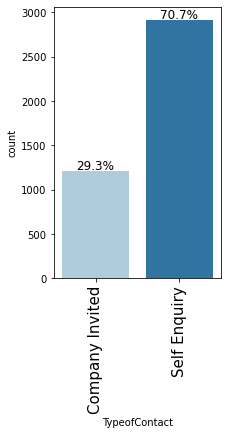

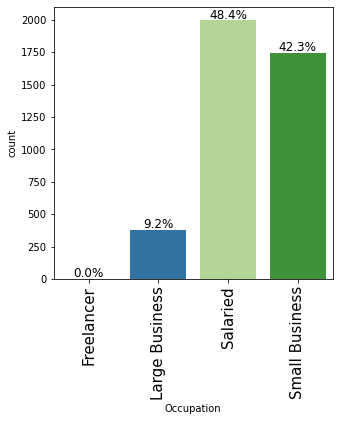

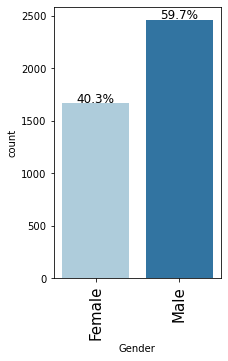

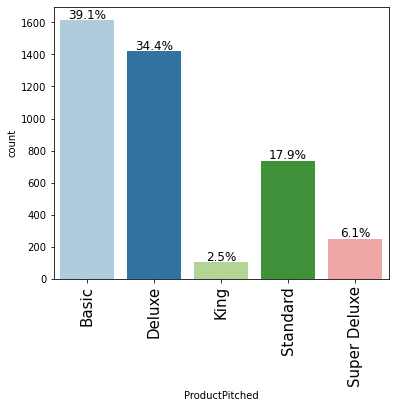

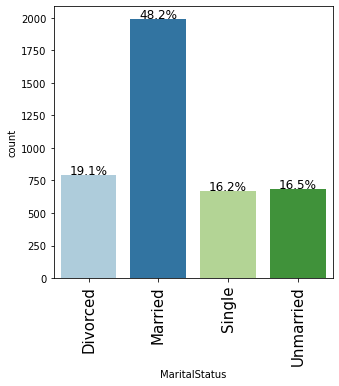

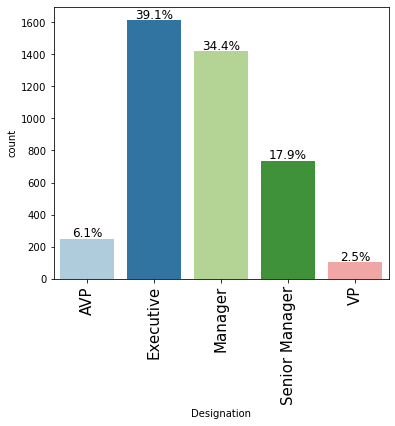

In [12]:
data["Gender"] = data["Gender"].replace("Fe Male", "Female")
data["Occupation"] = data["Occupation"].replace("Free Lancer", "Freelancer")

for x in data.select_dtypes(include='object').columns:
    labeled_barplot(data, x, perc=True)

UNIVARIATE ANALYSIS  <br>
Type of Contact: Approximately 30% of customers were company invited and 70% inquired about the travel package on their own which is a little under three fourths of customers inquiring without company invitation. <br>
Occupation: Almost half (48.8%) of inquiries were from salaried customers and the next most inquires came from small business owners (42.3%.) Meanwhile no freelancers inquired with remaining inquires (9.2%) coming from large business owners. <br>
Gender: More than half (59.7%) of inquiries were from males. <br>
Product Pitched: Most customers recieved a pitch for the lower-end products. The 'Basic' was pitched the most, 39.1%. The least pitched product was the 'King' at only 2.5%.  <br>
Marital Status: Almost half (48.2%) of the customers were married. The remaining customers are somewhat evenly split between divorced (19.1%), single (16.2%), and unmarried (16.5%.)  <br>
Designation: Majority of customers were executives (39.1%) and about a third (34.4%) were managers. The fewest customers have an AVP (6.1%) and VP (2.5%) position. A significant portion, 17.9% of customers are senior managers. <br>


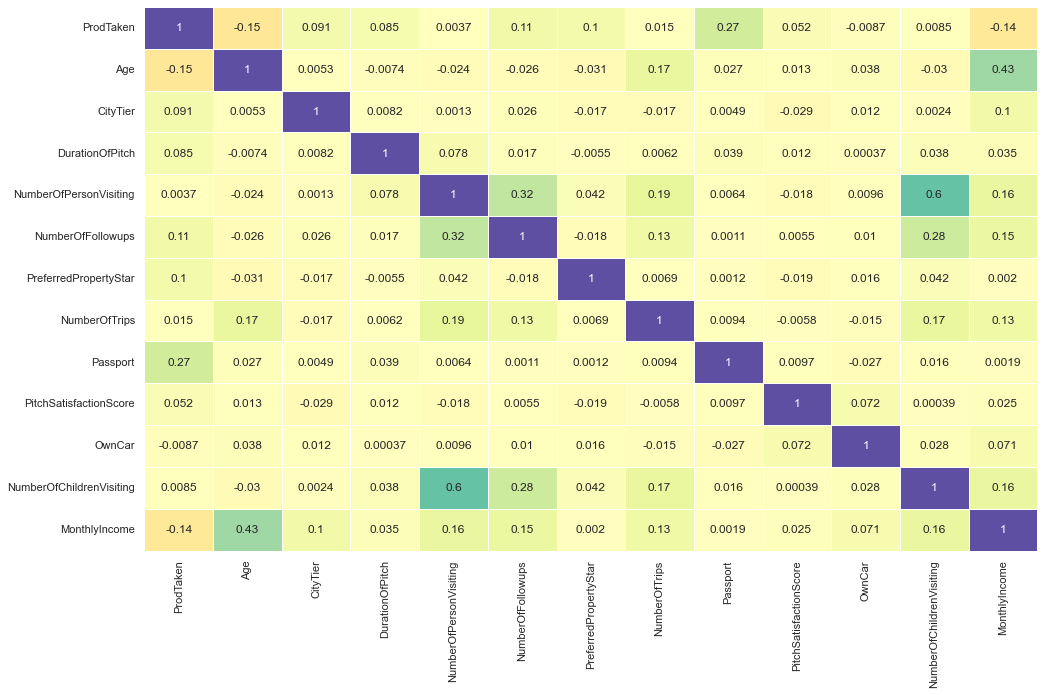

In [13]:
sns.set(rc={'figure.figsize':(16,10)})
sns.heatmap(data.corr(),
            annot=True,
            linewidths=.5,
            center=0,
            cbar=False,
            cmap="Spectral")
plt.show()

It seems that only two sets of variables are truly related. <br>
These two sets are:
1. Number of People Visiting and Number of Children Visiting: This is because on average, if there are more children visiting, there will also be more people visiting.<br>
2. Age and Monthly Income: This is because the older you get, the more you earn.

In [39]:
# function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100


# function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    r2 = r2_score(target, pred)  # to compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)  # to compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # to compute RMSE
    mae = mean_absolute_error(target, pred)  # to compute MAE
    mape = mape_score(target, pred)  # to compute MAPE

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf


##  Function to calculate r2_score and RMSE on train and test data
def get_model_score(model, flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    score_list=[] 
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    train_r2=metrics.r2_score(y_train,pred_train)
    test_r2=metrics.r2_score(y_test,pred_test)
    train_rmse=np.sqrt(metrics.mean_squared_error(y_train,pred_train))
    test_rmse=np.sqrt(metrics.mean_squared_error(y_test,pred_test))
    
    #Adding all scores in the list
    score_list.extend((train_r2,test_r2,train_rmse,test_rmse))
    
    # If the flag is set to True then only the following print statements will be dispayed, the default value is True
    if flag==True: 
        print("R-square on training set : ",metrics.r2_score(y_train,pred_train))
        print("R-square on test set : ",metrics.r2_score(y_test,pred_test))
        print("RMSE on training set : ",np.sqrt(metrics.mean_squared_error(y_train,pred_train)))
        print("RMSE on test set : ",np.sqrt(metrics.mean_squared_error(y_test,pred_test)))
    
    # returning the list with train and test scores
    return score_list


# Copy some functions from the example code
def model_performance_classification_sklearn_with_threshold(
    model, predictors, target, threshold=0.5
):
    """
    Function to compute different metrics, based on the threshold specified, to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """

    # predicting using the independent variables
    pred_prob = model.predict_proba(predictors)[:, 1]
    pred_thres = pred_prob > threshold
    pred = np.round(pred_thres)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf


# defining a function to plot the confusion_matrix of a classification model built using sklearn
def confusion_matrix_sklearn_with_threshold(model, predictors, target, threshold=0.5):
    """
    To plot the confusion_matrix, based on the threshold specified, with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """
    pred_prob = model.predict_proba(predictors)[:, 1]
    pred_thres = pred_prob > threshold
    y_pred = np.round(pred_thres)

    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")


def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [15]:
data = pd.get_dummies(data)
X = data.drop('ProdTaken', axis=1)
y = data['ProdTaken']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1, shuffle=True)

In [16]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [17]:
#Create Decision Tree
dtree=DecisionTreeRegressor(random_state=1)
dtree.fit(X_train,y_train)

DecisionTreeRegressor(random_state=1)

In [18]:
dtree_model_train_perf=model_performance_regression(dtree, X_train,y_train)
print("Training performance \n",dtree_model_train_perf)
#Very overfit. We can see that the R squared value is perfect.

Training performance 
    RMSE  MAE  R-squared  Adj. R-squared  MAPE
0   0.0  0.0        1.0             1.0   0.0


In [22]:
dtree_tuned_model_test_perf = model_performance_regression(dtree, X_test,y_test)
print("Testing performance \n",dtree_tuned_model_test_perf)
#Very low R squared value, probably because the model is so overfit

Testing performance 
        RMSE       MAE  R-squared  Adj. R-squared  MAPE
0  0.300658  0.090395   0.437069        0.421173   inf





Training performance:
   RMSE  MAE  R-squared  Adj. R-squared  MAPE
0   0.0  0.0        1.0             1.0   0.0


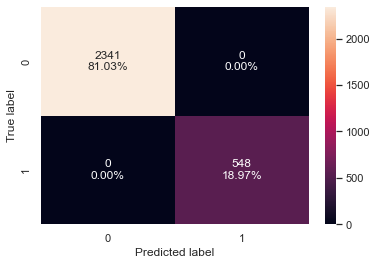

In [76]:
confused = confusion_matrix_sklearn(dtree, X_train, y_train)
dtree_model_train_perf = model_performance_regression(
    dtree, X_train, y_train
)

print("\n\n\nTraining performance:")
print(dtree_model_train_perf)
# As can be seen by the results below, this model performs very well in general. It has an accuracy of 95 percent, but its recall
# leaves something to be desired.




Training performance:
       RMSE       MAE  R-squared  Adj. R-squared  MAPE
0  0.300658  0.090395   0.437069        0.421173   inf


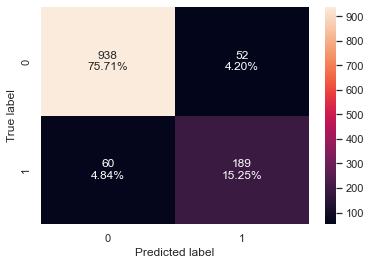

In [80]:
confused = confusion_matrix_sklearn(dtree, X_test, y_test)
dtree_model_test_perf = model_performance_regression(
    dtree, X_test, y_test
)

print("\n\n\nTraining performance:")
print(dtree_model_test_perf)

In [19]:
#Let's try and optimize this tree if possible
dtree_tuned = DecisionTreeRegressor(random_state=1)

parameters = {'max_depth': list(np.arange(2,20)) + [None], 
              'min_samples_leaf': [1, 3, 5, 7, 10],
              'max_leaf_nodes' : [2, 3, 5, 10, 15] + [None],
              'min_impurity_decrease': [0.001, 0.01, 0.1, 0.0]
             }

scorer = metrics.make_scorer(metrics.r2_score)

grid_obj = GridSearchCV(dtree_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

dtree_tuned = grid_obj.best_estimator_

dtree_tuned.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=8, min_samples_leaf=3, random_state=1)

In [48]:
dtree_tuned_model_train_perf = model_performance_regression(dtree_tuned, X_train,y_train)
print("Training performance \n",dtree_model_train_perf)
#Incredibly overfit still. This does not bode well for the testing data.

Training performance 
    RMSE  MAE  R-squared  Adj. R-squared  MAPE
0   0.0  0.0        1.0             1.0   0.0


In [21]:
dtree_tuned_model_test_perf = model_performance_regression(dtree_tuned, X_test,y_test)
print("Testing performance \n",dtree_tuned_model_test_perf)
#This model is worse than the original. It seems that that model cannot be improved on. This does make sense, however, since
#none of the variables have any correlation with each other and definitely not with the output. This means that it is hard to 
#find a model that will work for this.

Testing performance 
        RMSE       MAE  R-squared  Adj. R-squared  MAPE
0  0.332108  0.184268    0.31314        0.293744   inf


In [23]:
rf_estimator=RandomForestRegressor(random_state=1)
rf_estimator.fit(X_train,y_train)

RandomForestRegressor(random_state=1)

In [24]:
rf_estimator_model_train_perf = model_performance_regression(rf_estimator, X_train,y_train)
print("Training performance \n",rf_estimator_model_train_perf)
#Much less overfit.

Training performance 
      RMSE       MAE  R-squared  Adj. R-squared  MAPE
0  0.0931  0.057352   0.943609        0.942937   inf


In [25]:
rf_estimator_model_test_perf = model_performance_regression(rf_estimator, X_test,y_test)
print("Testing performance \n",rf_estimator_model_test_perf)
#This is a much better R squared value. It explains 61% of the data.

Testing performance 
        RMSE       MAE  R-squared  Adj. R-squared  MAPE
0  0.247571  0.159023   0.618314        0.607535   inf


In [26]:
#We can now create a random forest regressor
rf_tuned = RandomForestRegressor(random_state=1)

parameters = {  
                'max_depth':[4, 6, 8, 10, None],
                'max_features': ['sqrt','log2',None],
                'n_estimators': [80, 90, 100, 110, 120]
}

scorer = metrics.make_scorer(metrics.r2_score)

grid_obj = GridSearchCV(rf_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

rf_tuned = grid_obj.best_estimator_

rf_tuned.fit(X_train, y_train)

#It looks like this is the exact same still.

RandomForestRegressor(max_features=None, random_state=1)

In [82]:
rf_tuned_model_train_perf = model_performance_regression(rf_tuned, X_train,y_train)
print("Training performance \n",rf_estimator_model_train_perf)
#Much less overfit.

Training performance 
      RMSE       MAE  R-squared  Adj. R-squared  MAPE
0  0.0931  0.057352   0.943609        0.942937   inf


In [83]:
rf_tuned_model_test_perf = model_performance_regression(rf_tuned, X_test,y_test)
print("Testing performance \n",rf_estimator_model_test_perf)
#This is a much better R squared value. It explains 61% of the data.

Testing performance 
        RMSE       MAE  R-squared  Adj. R-squared  MAPE
0  0.247571  0.159023   0.618314        0.607535   inf


In [28]:
print(pd.DataFrame(rf_tuned.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(by = 'Imp', ascending = False))
#It seems that many of these are not important other than the age, duration of pitch and monthly income.

                                    Imp
Age                            0.133120
DurationOfPitch                0.130231
MonthlyIncome                  0.117157
Passport                       0.070593
NumberOfTrips                  0.062900
PitchSatisfactionScore         0.055975
NumberOfFollowups              0.053195
CityTier                       0.041895
ProductPitched_Basic           0.036409
Designation_Executive          0.036376
PreferredPropertyStar          0.033061
MaritalStatus_Single           0.022102
NumberOfChildrenVisiting       0.019802
Occupation_Large Business      0.017710
NumberOfPersonVisiting         0.017417
MaritalStatus_Married          0.017161
MaritalStatus_Unmarried        0.016128
OwnCar                         0.015063
Gender_Female                  0.012478
Gender_Male                    0.012449
Occupation_Small Business      0.012390
Occupation_Salaried            0.011323
TypeofContact_Company Invited  0.011145
TypeofContact_Self Enquiry     0.011052


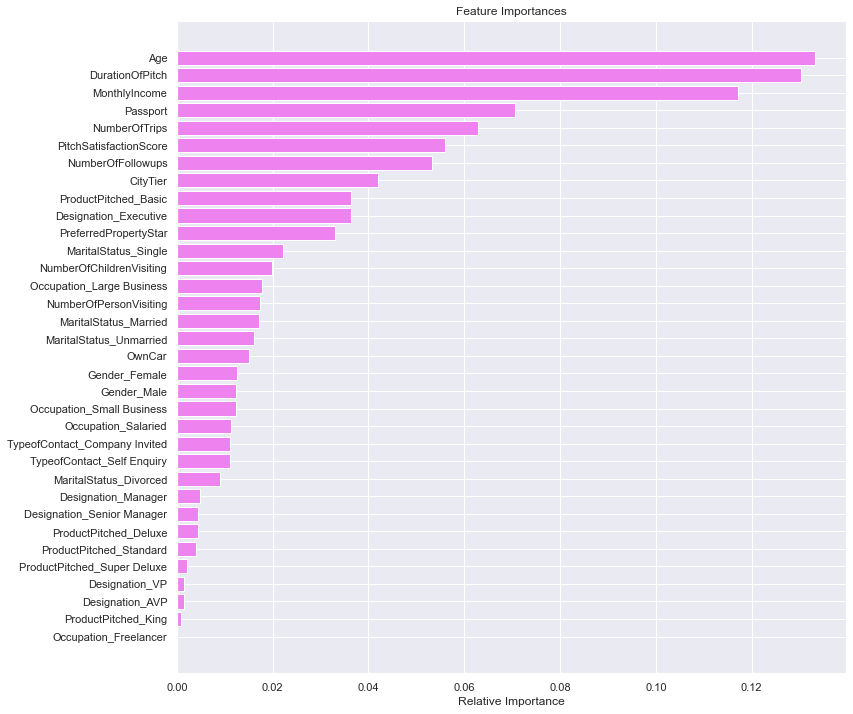

In [29]:
feature_names = X_train.columns
importances = rf_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [30]:
ab_regressor=AdaBoostRegressor(random_state=1)
ab_regressor.fit(X_train,y_train)

AdaBoostRegressor(random_state=1)

In [31]:
ab_regressor_model_train_perf = model_performance_regression(ab_regressor, X_train,y_train)
print("Training performance \n",ab_regressor_model_train_perf)
#Fairly low R squared. This model does not seem very good if this is what it is finding on the training data.

Training performance 
        RMSE       MAE  R-squared  Adj. R-squared  MAPE
0  0.356256  0.243154   0.174273        0.164436   inf


In [32]:
ab_regressor_model_test_perf = model_performance_regression(ab_regressor, X_test,y_test)
print("Testing performance \n",ab_regressor_model_test_perf)
#Even lower R squared. 

Testing performance 
        RMSE      MAE  R-squared  Adj. R-squared  MAPE
0  0.371882  0.25493   0.138773        0.114452   inf


In [49]:
# Choose the type of classifier. 
ab_tuned = AdaBoostRegressor(random_state=1)

# Grid of parameters to choose from
parameters = {'n_estimators': np.arange(10,100,10), 
              'learning_rate': [1, 0.1, 0.5, 0.01],
              }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.r2_score)

# Run the grid search
grid_obj = GridSearchCV(ab_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
ab_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
ab_tuned.fit(X_train, y_train)

AdaBoostRegressor(learning_rate=0.01, n_estimators=90, random_state=1)

In [50]:
ab_tuned_model_train_perf = model_performance_regression(ab_tuned, X_train,y_train)
print("Training performance \n",ab_tuned_model_train_perf)
#Although much improved from the non-tuned version of the boost, it is still not even close to as accurate as the random forest

Training performance 
        RMSE       MAE  R-squared  Adj. R-squared  MAPE
0  0.346006  0.257167   0.221101        0.211822   inf


In [51]:
ab_tuned_model_test_perf = model_performance_regression(ab_tuned, X_test,y_test)
print("Testing performance \n",ab_tuned_model_train_perf)
#This somehow has the same stats as the training data.

Testing performance 
        RMSE       MAE  R-squared  Adj. R-squared  MAPE
0  0.346006  0.257167   0.221101        0.211822   inf


In [52]:
print(pd.DataFrame(ab_tuned.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(by = 'Imp', ascending = False))

                                    Imp
Passport                       0.330224
ProductPitched_Basic           0.126547
Designation_Executive          0.119047
Age                            0.114081
DurationOfPitch                0.072082
CityTier                       0.056095
MaritalStatus_Single           0.045357
NumberOfFollowups              0.035150
MonthlyIncome                  0.025128
Occupation_Large Business      0.017504
PreferredPropertyStar          0.016661
MaritalStatus_Married          0.008979
Designation_Manager            0.008038
PitchSatisfactionScore         0.007175
ProductPitched_Deluxe          0.006473
NumberOfTrips                  0.005202
MaritalStatus_Unmarried        0.002289
NumberOfPersonVisiting         0.002104
Occupation_Small Business      0.000983
ProductPitched_Standard        0.000557
Designation_Senior Manager     0.000325
Gender_Male                    0.000000
Gender_Female                  0.000000
Occupation_Salaried            0.000000


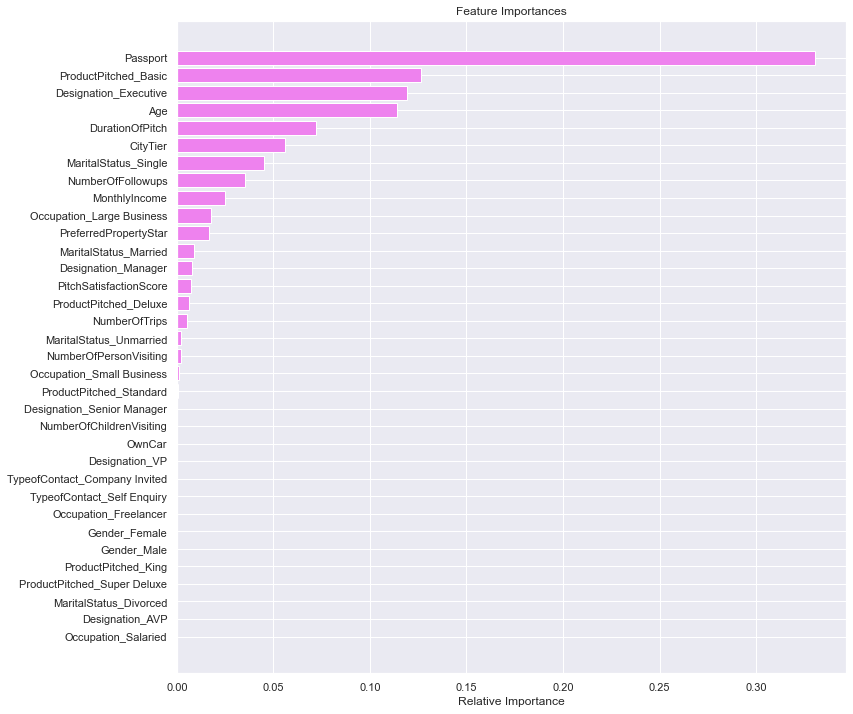

In [53]:
feature_names = X_train.columns
importances = ab_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()
#For what ever reason, it seems that having a passport is what seems most important to this type of learning. It is not clear
#why this is, because the previous one is far more accurate and it focuses on very different variables.

In [54]:
gb_estimator=GradientBoostingRegressor(random_state=1)
gb_estimator.fit(X_train,y_train)

GradientBoostingRegressor(random_state=1)

In [55]:
gb_estimator_model_train_perf = model_performance_regression(gb_estimator, X_train,y_train)
print("Training performance \n",gb_estimator_model_train_perf)
#All things considered, it is a very decent model. Let's check in the testing set

Training performance 
        RMSE       MAE  R-squared  Adj. R-squared  MAPE
0  0.289361  0.199418   0.455255        0.448765   inf


In [57]:
gb_estimator_model_test_perf = model_performance_regression(gb_estimator, X_test, y_test)
print("Testing performance \n",gb_estimator_model_test_perf)
#Also fairly solid. This is the best r squared value we've had when not tuned for the test set. 

Testing performance 
        RMSE       MAE  R-squared  Adj. R-squared  MAPE
0  0.320945  0.221785   0.358539        0.340424   inf


In [58]:
# Choose the type of classifier. 
gb_tuned = GradientBoostingRegressor(random_state=1)

# Grid of parameters to choose from
parameters = {'n_estimators': np.arange(50,200,25), 
              'subsample':[0.7,0.8,0.9,1],
              'max_features':[0.7,0.8,0.9,1],
              'max_depth':[3,5,7,10]
              }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.r2_score)

# Run the grid search
grid_obj = GridSearchCV(gb_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
gb_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
gb_tuned.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=10, max_features=0.8, n_estimators=175,
                          random_state=1, subsample=0.7)

In [59]:
gb_tuned_model_train_perf = model_performance_regression(gb_tuned, X_train,y_train)
print("Training performance \n",gb_tuned_model_train_perf)
#This is a very high R squared value, which may mean it's overfit

Training performance 
        RMSE       MAE  R-squared  Adj. R-squared  MAPE
0  0.002504  0.001846   0.999959        0.999959   inf


In [60]:
gb_tuned_model_test_perf = model_performance_regression(gb_tuned, X_test, y_test)
print("Testing performance \n",gb_tuned_model_test_perf)
#The R squared is the highest it's been for any of the models. This model is able to explain 66% of the data.

Testing performance 
        RMSE      MAE  R-squared  Adj. R-squared  MAPE
0  0.232242  0.13243   0.664117        0.654631   inf


In [61]:
print(pd.DataFrame(gb_tuned.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(by = 'Imp', ascending = False))

                                        Imp
DurationOfPitch                1.356204e-01
MonthlyIncome                  1.314967e-01
Age                            1.269178e-01
NumberOfTrips                  6.894477e-02
Passport                       6.489058e-02
NumberOfFollowups              5.243122e-02
PitchSatisfactionScore         5.196688e-02
CityTier                       3.650572e-02
PreferredPropertyStar          3.401545e-02
Designation_Executive          3.260351e-02
ProductPitched_Basic           2.559546e-02
NumberOfChildrenVisiting       2.203854e-02
NumberOfPersonVisiting         2.032207e-02
MaritalStatus_Single           1.986051e-02
Occupation_Large Business      1.832580e-02
MaritalStatus_Married          1.676068e-02
MaritalStatus_Unmarried        1.653505e-02
Gender_Male                    1.530228e-02
TypeofContact_Company Invited  1.510527e-02
TypeofContact_Self Enquiry     1.376999e-02
Gender_Female                  1.276532e-02
Occupation_Salaried            1

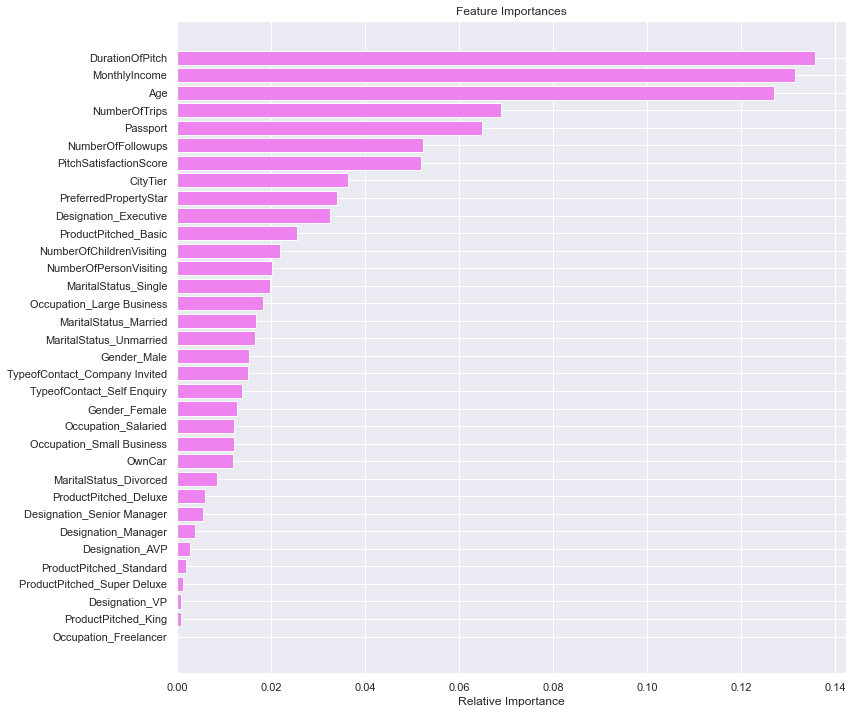

In [62]:
feature_names = X_train.columns
importances = gb_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()
#Other than giving Age a lower importance, this model seems very similar to the tuned random forest in terms of feature 
#importance.

In [63]:
xgb_estimator=XGBRegressor(random_state=1)
xgb_estimator.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=1, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [64]:
xgb_estimator_model_train_perf = model_performance_regression(xgb_estimator, X_train, y_train)
print("Training performance \n",xgb_estimator_model_train_perf)
#Very high R squared value

Training performance 
        RMSE       MAE  R-squared  Adj. R-squared  MAPE
0  0.063082  0.039923   0.974111        0.973802   inf


In [65]:
xgb_estimator_model_test_perf = model_performance_regression(xgb_estimator, X_test,y_test)
print("Testing performance \n",xgb_estimator_model_test_perf)
#R squared value is almost as good as the tuned models. This is clearly the way to go.

#Took WAY too long to tune

Testing performance 
        RMSE       MAE  R-squared  Adj. R-squared  MAPE
0  0.251831  0.155777   0.605064        0.593911   inf


In [67]:
estimators=[('Decision Tree', dtree_tuned),('Random Forest', rf_tuned),
           ('Gradient Boosting', gb_tuned)]
final_estimator=XGBRegressor(random_state=1)

In [68]:
stacking_estimator=StackingRegressor(estimators=estimators, final_estimator=final_estimator,cv=5)
stacking_estimator.fit(X_train,y_train)

StackingRegressor(cv=5,
                  estimators=[('Decision Tree',
                               DecisionTreeRegressor(max_depth=8,
                                                     min_samples_leaf=3,
                                                     random_state=1)),
                              ('Random Forest',
                               RandomForestRegressor(max_features=None,
                                                     random_state=1)),
                              ('Gradient Boosting',
                               GradientBoostingRegressor(max_depth=10,
                                                         max_features=0.8,
                                                         n_estimators=175,
                                                         random_state=1,
                                                         subsample=0.7))],
                  final_estimator=XGBRegressor(ba...
                                               intera

In [69]:
stacking_estimator_model_train_perf = model_performance_regression(stacking_estimator, X_train, y_train)
print("Training performance \n",stacking_estimator_model_train_perf)
#Highest initial performance so far, narrowly beating XGBoost

Training performance 
        RMSE       MAE  R-squared  Adj. R-squared  MAPE
0  0.055618  0.020337   0.979875        0.979635   inf


In [70]:
stacking_estimator_model_test_perf = model_performance_regression(stacking_estimator, X_test, y_test)
print("Testing performance \n",stacking_estimator_model_test_perf)
#Although the testing data is not as accurate as XGBoost, at least it doesn't take as long to run

Testing performance 
        RMSE       MAE  R-squared  Adj. R-squared  MAPE
0  0.253476  0.111176   0.599888        0.588589   inf


In [73]:
# training performance comparison

models_train_comp_df = pd.concat(
    [dtree_model_train_perf.T, dtree_tuned_model_train_perf.T, rf_estimator_model_train_perf.T,rf_tuned_model_train_perf.T,
    ab_regressor_model_train_perf.T,ab_tuned_model_train_perf.T,gb_estimator_model_train_perf.T,gb_tuned_model_train_perf.T,
    xgb_estimator_model_train_perf.T,stacking_estimator_model_train_perf.T],
    axis=1,
)

models_train_comp_df.columns = [
    "Decision Tree",
    "Decision Tree Tuned",
    "Random Forest Estimator",
    "Random Forest Tuned",
    "Adaboost Regressor",
    "Adaboost Tuned",
    "Gradient Boost Estimator",
    "Gradient Boost Tuned",
    "XGB",
    "Stacking Classifier"
]

print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Decision Tree,Decision Tree Tuned,Random Forest Estimator,Random Forest Tuned,Adaboost Regressor,Adaboost Tuned,Gradient Boost Estimator,Gradient Boost Tuned,XGB,Stacking Classifier
RMSE,0.0,0.265171,0.093100,0.093100,0.356256,0.346006,0.289361,0.002504,0.063082,0.055618
MAE,0.0,0.140632,0.057352,0.057352,0.243154,0.257167,0.199418,0.001846,0.039923,0.020337
R-squared,1.0,0.542527,0.943609,0.943609,0.174273,0.221101,0.455255,0.999959,0.974111,0.979875
Adj. R-squared,1.0,0.537077,0.942937,0.942937,0.164436,0.211822,0.448765,0.999959,0.973802,0.979635
MAPE,0.0,inf,inf,inf,inf,inf,inf,inf,inf,inf


In [84]:
# Testing performance comparison

models_test_comp_df = pd.concat(
    [dtree_model_test_perf.T, dtree_tuned_model_test_perf.T, rf_estimator_model_test_perf.T,rf_tuned_model_test_perf.T,
    ab_regressor_model_test_perf.T,ab_tuned_model_test_perf.T,gb_estimator_model_test_perf.T,gb_tuned_model_test_perf.T,
    xgb_estimator_model_test_perf.T,stacking_estimator_model_test_perf.T],
    axis=1,
)

models_test_comp_df.columns = [
    "Decision Tree",
    "Decision Tree Tuned",
    "Random Forest Estimator",
    "Random Forest Tuned",
    "Adaboost Regressor",
    "Adaboost Tuned",
    "Gradient Boost Estimator",
    "Gradient Boost Tuned",
    "XGB",
    "Stacking Classifier"
]

print("Testing performance comparison:")
models_test_comp_df

Testing performance comparison:


,Decision Tree,Decision Tree Tuned,Random Forest Estimator,Random Forest Tuned,Adaboost Regressor,Adaboost Tuned,Gradient Boost Estimator,Gradient Boost Tuned,XGB,Stacking Classifier
RMSE,0.300658,0.300658,0.247571,0.247571,0.371882,0.356376,0.320945,0.232242,0.251831,0.253476
MAE,0.090395,0.090395,0.159023,0.159023,0.254930,0.263035,0.221785,0.132430,0.155777,0.111176
R-squared,0.437069,0.437069,0.618314,0.618314,0.138773,0.209095,0.358539,0.664117,0.605064,0.599888
Adj. R-squared,0.421173,0.421173,0.607535,0.607535,0.114452,0.186760,0.340424,0.654631,0.593911,0.588589
MAPE,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


<b>KEY TAKEAWAYS </b><br>
As can be seen by this data, the most important feature in determining whether a customer will choose a this product or not is Duration of Pitch. It seems that the longer the pitch, the more likely a customer is to buy this product.<br>
Perhaps training should be given to the employees of this store to make their pitches as long as possible or as informative as possible. <br>
Another interesting statistic to note is Age. It seems that Age plays a large role in determining whether or not a certain demographic will purchase this product. The company should spread where the advertise their sales because customers of all ages seem to be interested but specifically target places heavily visited by 30 years olds since they were the main customers. Also, most customers seemed to have visited with at least one child under 5. Advertising on channels watched by adults around 30-40 or children's channels will be beneficial. <br>
Having a passport was another variable shared amongst most customers. Promoting their pitch at passport centers will catch the attention of those with new or renewed passports who seem to be more likely to come. <br>
Similar to the passport approach, pitching at airports or travel agencies, places visited often by people who take many annual trips and can afford trips will generate success. <br>
This is also related to monthly income. Targeting stores or communities frequented by higher income families will increase product sales. <br>

